In [1]:
import numpy as np
from obspy import UTCDateTime
import obspy as obs
from obspy.clients.fdsn import Client as FDSN_Client
import numpy as np
from matplotlib import pyplot as plt
import sys
from ground_motion_qh import extract_pairs
from ground_motion_qh.catalog import Catalog
from ground_motion_qh.earthquake import EarthquakeCatalog
# import earthquake import EarthquakeCatalog
from pathlib import Path
from ground_motion_qh.get_waveforms import get_stream_multiple_stations, raw_stream_to_amplitude_and_times
    

In [2]:
earquake_metadata = {
    "starttime": '2000-01-01',
    "endtime": '2023-01-01',
    "latitude_range": [33,34],
    "longitude_range": [-117,-116],
    "minimum_magnitude": 3.0, 
}

station_metadata = dict(
    stname = ["SND"],
    network = "AZ",
    org = "IRIS",
)

In [3]:
earthquakes = EarthquakeCatalog(
    filename="local_catalog.csv",
    kwargs=earquake_metadata,
)

/Users/kdascher/Documents/Documents/USU/Projects/Exploratory_projects/GroundMotion_QH/ground_motion_qh/earthquake.py:196: UserWarning: Reloading local_catalog.csv
  warnings.warn(f"Reloading {filename}")


<Axes: xlabel='Time', ylabel='mag'>

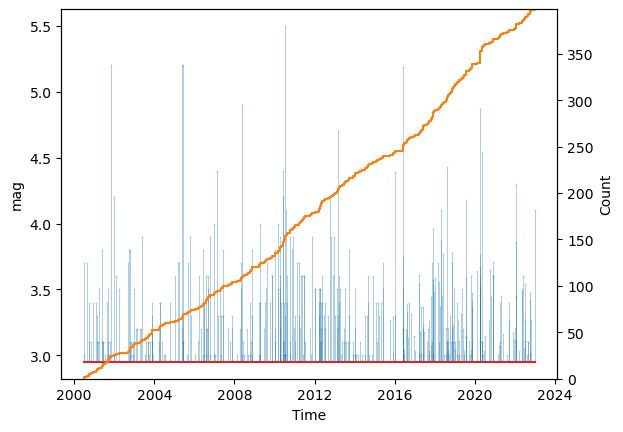

In [4]:
earthquakes.plot_time_series()

In [5]:
event_time_window = 30 # seconds (also we refer to this as tw-)
buffer = 0
forecast_time_window = 60*60 # seconds (also we refer to this as tw+)


In [6]:
A_pre = []
A_post = []

for i, t0 in enumerate(earthquakes.catalog.time):
    print(f"Dowloading event {i}")
    
    try:
        stream_dict = get_stream_multiple_stations(
            t1=UTCDateTime(t0),
            t2=UTCDateTime(t0 + np.timedelta64(event_time_window, "s")),
        )
        a_trigger, _ = raw_stream_to_amplitude_and_times(stream_dict["SND"])

        stream_dict = get_stream_multiple_stations(
            t1=UTCDateTime(t0 + np.timedelta64(event_time_window + buffer, "s")),
            t2=UTCDateTime(t0 + np.timedelta64(event_time_window + buffer + forecast_time_window, "s")),
        )
        a_forecast, _ = raw_stream_to_amplitude_and_times(stream_dict["SND"])
        
        A_pre.append(a_trigger)
        A_post.append(a_forecast)
        
    except Exception as e:
        print(f"Error dowloading event {i}: {e}")
        A_pre.append(np.array([]))
        A_post.append(np.array([]))
        
        continue

Dowloading event 0
Dowloading event 1
Dowloading event 2
Dowloading event 3
Dowloading event 4
Dowloading event 5
Dowloading event 6
Dowloading event 7
Dowloading event 8
Dowloading event 9
Dowloading event 10
Dowloading event 11
Dowloading event 12
Dowloading event 13
Dowloading event 14
Dowloading event 15
Dowloading event 16
Dowloading event 17
Dowloading event 18
Dowloading event 19
Dowloading event 20
Dowloading event 21
Dowloading event 22
Dowloading event 23
Dowloading event 24
Error dowloading event 24: operands could not be broadcast together with shapes (6665,) (12076,) 
Dowloading event 25
Error dowloading event 25: operands could not be broadcast together with shapes (6105,) (225620,) 
Dowloading event 26
Dowloading event 27
Dowloading event 28
Dowloading event 29
Dowloading event 30
Dowloading event 31
Dowloading event 32
Dowloading event 33
Dowloading event 34
Dowloading event 35
Dowloading event 36
Dowloading event 37
Dowloading event 38
Dowloading event 39
Dowloading ev

In [10]:
a_forecast_max = np.array([np.max(np.abs(a-np.mean(a))) for a in A_post if np.any(a)])
a_trigger_max = np.array([np.max(np.abs(a-np.mean(a))) for a in A_pre if np.any(a)])


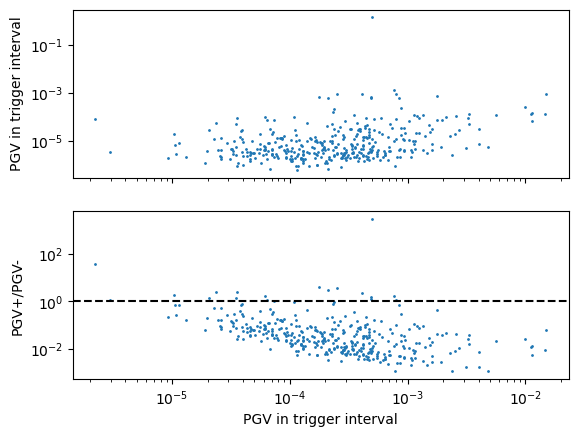

In [14]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].scatter(a_trigger_max, a_forecast_max, s=1)
ax[0].set(
    ylabel="PGV in trigger interval",
    yscale="log",
)

ax[1].scatter(a_trigger_max, a_forecast_max/a_trigger_max, s=1)
ax[1].set(
    xlabel="PGV in trigger interval",
    ylabel="PGV+/PGV-",
    yscale="log",
    xscale="log",
)
ax[1].axhline(1, color="k", linestyle="--")


In [15]:
np.mean(a_forecast_max/a_trigger_max>1)

np.float64(0.05026455026455026)

In [16]:
# save a_forecast_max and a_trigger_max
np.save("a_forecast_max.npy", a_forecast_max)
np.save("a_trigger_max.npy", a_trigger_max)